In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Prepare the Data

In [18]:
# Load Data
salary_df = pd.read_csv("resources/data_science_salaries.csv")
salary_df.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


In [19]:
# Log Transform Salary to Handle Outliers
salary_df = salary_df.loc[salary_df["salary_in_usd"] <= 650000]
salary_df["salary_in_usd"] = np.log(salary_df["salary_in_usd"])

In [20]:
# Selecting Features & Target
X = salary_df.drop(columns=["salary", "salary_currency", "salary_in_usd"])
y = salary_df["salary_in_usd"]

In [21]:
# Splitting Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Identify Categorical and Numerical Features
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns

In [23]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

In [24]:
# Model Pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("ridge", Ridge(alpha=1.0))  # Regularized Linear Regression
])

In [25]:
print(X_train.head())
print(y_train.head())

                            job_title experience_level employment_type  \
2591                   Data Scientist     Senior-level       Full-time   
4406            Data Science Engineer     Senior-level       Full-time   
6315             Data Science Manager     Senior-level       Full-time   
1897  Business Intelligence Developer        Mid-level       Full-time   
1643                Research Engineer        Mid-level       Full-time   

     work_models  work_year employee_residence company_location company_size  
2591     On-site       2023      United States    United States       Medium  
4406     On-site       2023      United States    United States       Medium  
6315     On-site       2021      United States    United States        Large  
1897      Remote       2023      United States    United States       Medium  
1643      Remote       2023      United States    United States       Medium  
2591    12.268014
4406    11.849398
6315    12.388394
1897    11.608236
1643    1

In [26]:
# Train Model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

/Users/tlockhart/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
# Convert back from log scale
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

In [28]:
# Evaluate Model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"MSE: {mse:.4f}")

R²: 0.5211
Adjusted R²: 0.5181
MSE: 0.1434


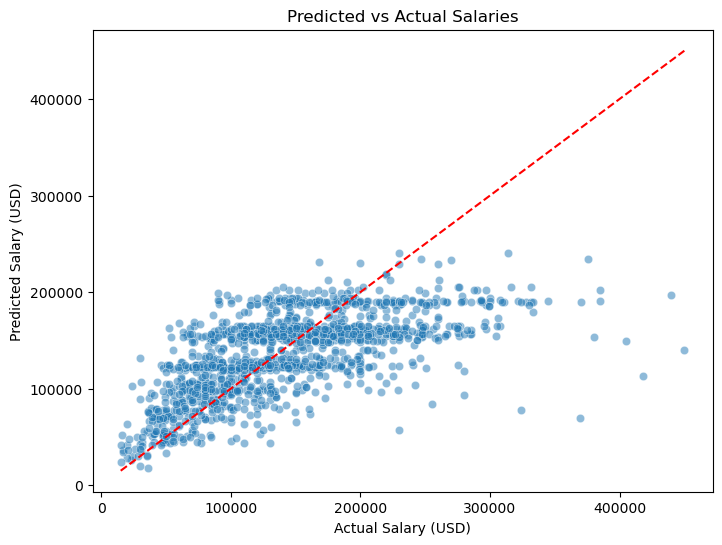

In [29]:
# Plot Predicted vs Actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_exp, y=y_pred_exp, alpha=0.5)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], color='red', linestyle='--')
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Predicted vs Actual Salaries")
plt.show()

In [30]:
# Gradio Interface Function
def predict_salary(job_title, experience_level, employment_type, work_models, work_year, company_size, employee_residence, company_location):
    """Predicts salary based on user input from Gradio interface."""
    user_input = {
        "job_title": job_title,
        "experience_level": experience_level,
        "employment_type": employment_type,
        "work_models": work_models,
        "work_year": int(work_year),
        "company_size": company_size,
        "employee_residence": employee_residence,
        "company_location": company_location
    }

    user_df = pd.DataFrame([user_input])
    predicted_salary_log = model.predict(user_df)[0]
    predicted_salary = np.exp(predicted_salary_log)  # Convert back to normal scale
    return f"Predicted Salary: ${round(predicted_salary, 2)}" 


In [31]:
# Create Gradio Interface
job_titles = list(salary_df["job_title"].unique())
experience_levels = list(salary_df["experience_level"].unique())
employment_types = list(salary_df["employment_type"].unique())
work_models = list(salary_df["work_models"].unique())
company_sizes = list(salary_df["company_size"].unique())
employee_residences = list(salary_df["employee_residence"].unique())
company_locations = list(salary_df["company_location"].unique())

In [32]:
gr_interface = gr.Interface(
    fn=predict_salary,
    inputs=[
        gr.Dropdown(choices=job_titles, label="Job Title"),
        gr.Dropdown(choices=experience_levels, label="Experience Level"),
        gr.Dropdown(choices=employment_types, label="Employment Type"),
        gr.Dropdown(choices=work_models, label="Work Model"),
        gr.Number(label="Work Year"),
        gr.Dropdown(choices=company_sizes, label="Company Size"),
        gr.Dropdown(choices=employee_residences, label="Employee Residence"),
        gr.Dropdown(choices=company_locations, label="Company Location")
    ],
    outputs=gr.Textbox(label="Predicted Salary"),
    title="Salary Prediction App",
    description="Select your details and get an estimated salary prediction."
)

# Launch Gradio App
gr_interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://907f6d173e5f290694.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
